# Gold Scalper Signal 
by Chuwong K.

### Strategy
1. Use 21, 50, and 200 moving average in 5-min timeframe
2. Use RSI 14 to look for any divergence.
3. Enter if: Price do not smoosh to all MAs, MA signals (buy or sell), No RSI divergence, and there is an engulfing candle
4. Exit if: RSI divergence and price is over/under MA21.

### TODO:
[✅] MA signaling

[ ] Engulfing signal

[✅] RSI entry signal

[ ] RSI divergence signal

[ ] MA exit signal

### 1. Login to MetaTrader5 (this is a demo account)

In [14]:
!pip install MetaTrader5
!pip install mplfinance

In [15]:
import MetaTrader5 as mt5
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Connect to MetaTrader5
def loginMt5(account_id, password):        
    mt5.initialize(login=account_id, password=password, server='MetaQuotes-Demo')
    mt5.login()
    account_info = mt5.account_info()
        
    if not mt5.initialize():
        print('MetaTrader 5 initialization failed')
        print('Please check if your account or password is correct.')
        mt5.shutdown()
        
def logoutMt5():
    mt5.shutdown()
    
def getBalance():
    return mt5.account_info().balance

def getEquity():
    return mt5.account_info().equity

def check_gold_symbols():
    print(mt5.symbols_get())
    
def request_gold_ticks():
    # reqest 1 day of gold (5 minute chart)
    gold_rates = mt5.copy_rates_from_pos("XAUUSD", mt5.TIMEFRAME_M5, 0, 1440)
    gold_df = pd.DataFrame(gold_rates)
    gold_df = gold_df.drop(columns=['tick_volume', 'spread', 'real_volume'])
    
    return gold_df


In [16]:
loginMt5(59360656, 'evaww6lz')
data = request_gold_ticks()
print(data.head())

         time     open     high      low    close
0  1652738100  1817.99  1823.14  1817.82  1822.78
1  1652738400  1822.78  1823.30  1822.40  1822.84
2  1652738700  1822.84  1824.70  1822.83  1824.26
3  1652739000  1824.21  1824.66  1823.86  1824.03
4  1652739300  1824.04  1824.24  1823.85  1823.95


## 2. Calculate Indicators (MAs & RSI & Engulfing pattern)
___

In [17]:
def calculate_sma(df): 
    # calculate simple moving average
    df['sma_21'] = df['close'].rolling(21).mean()
    df['sma_50'] = df['close'].rolling(50).mean()
    df['sma_200'] = df['close'].rolling(200).mean()
    
    df['time'] = pd.to_datetime(df['time'], unit='s')
    
    # drop first 400 rows
    df = df.drop(df.index[(range(400))])
    df = df.reset_index()
    df = df.drop(['index'], axis=1)

    
    return df

def get_engulfing_pattern(prev_open, prev_close, cur_open, cur_close):
    prev_range = prev_close-prev_open
    cur_range = cur_close-cur_open
    
    # Bullish engulfing candle
    if(prev_range < 0 and cur_range > 0):
        if(abs(prev_range < cur_range) and prev_close < cur_close and prev_open > cur_open):
            return 'bullish'
        else:
            return None
        
    elif(prev_range > 0 and cur_range < 0):
        if(abs(prev_range > cur_range) and prev_close > cur_close and prev_open < cur_open):
            return 'bearish'
        else:
            return None
        
    return None 

# Function used to calculate RSI
def rma(x, n, y0):
    a = (n-1) / n
    ak = a**np.arange(len(x)-1, -1, -1)
    return np.r_[np.full(n, np.nan), y0, np.cumsum(ak * x) / ak / n + y0 * a**np.arange(1, len(x)+1)]


def calculate_rsi(df, period=14):
    n = 14
    temp = df.copy()
    temp['change'] = temp['close'].diff()
    temp['gain'] = temp.change.mask(temp.change < 0, 0.0)
    temp['loss'] = -temp.change.mask(temp.change > 0, -0.0)
    temp['avg_gain'] = rma(temp.gain[n+1:].to_numpy(), n, np.nansum(temp.gain.to_numpy()[:n+1])/n)
    temp['avg_loss'] = rma(temp.loss[n+1:].to_numpy(), n, np.nansum(temp.loss.to_numpy()[:n+1])/n)
    temp['rs'] = temp.avg_gain / temp.avg_loss
    df['rsi'] = 100 - (100 / (1 + temp.rs))
    
    return df


# plot the recent price with indicator
def plot_chart_with_indicators(df):
    fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
    fig.set_size_inches(20, 10)
    ax1.grid()
    ax2.grid()
    
    # PLot line graph
    ax1.plot(df.index, df['close'], color='black')

    # Plot SMA
    ax1.plot(df['close'], label='close', color='#4f4f4f')
    ax1.plot(df['sma_21'], label='sma_21', color='#4287f5')
    ax1.plot(df['sma_50'], label='sma_50', color='#1f6eed')
    ax1.plot(df['sma_200'], label='sma_200', color='#0456d9')
    
    # Plot RSI
    ax2.plot(df.index, df['rsi'], color='blue', alpha=0.7)
    ax2.axhline(y=70, color='red', linestyle='-', alpha=0.3)
    ax2.axhline(y=50, color='black', linestyle='-', alpha=0.4)
    ax2.axhline(y=30, color='red', linestyle='-', alpha=0.3)
    
    
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.show()
    

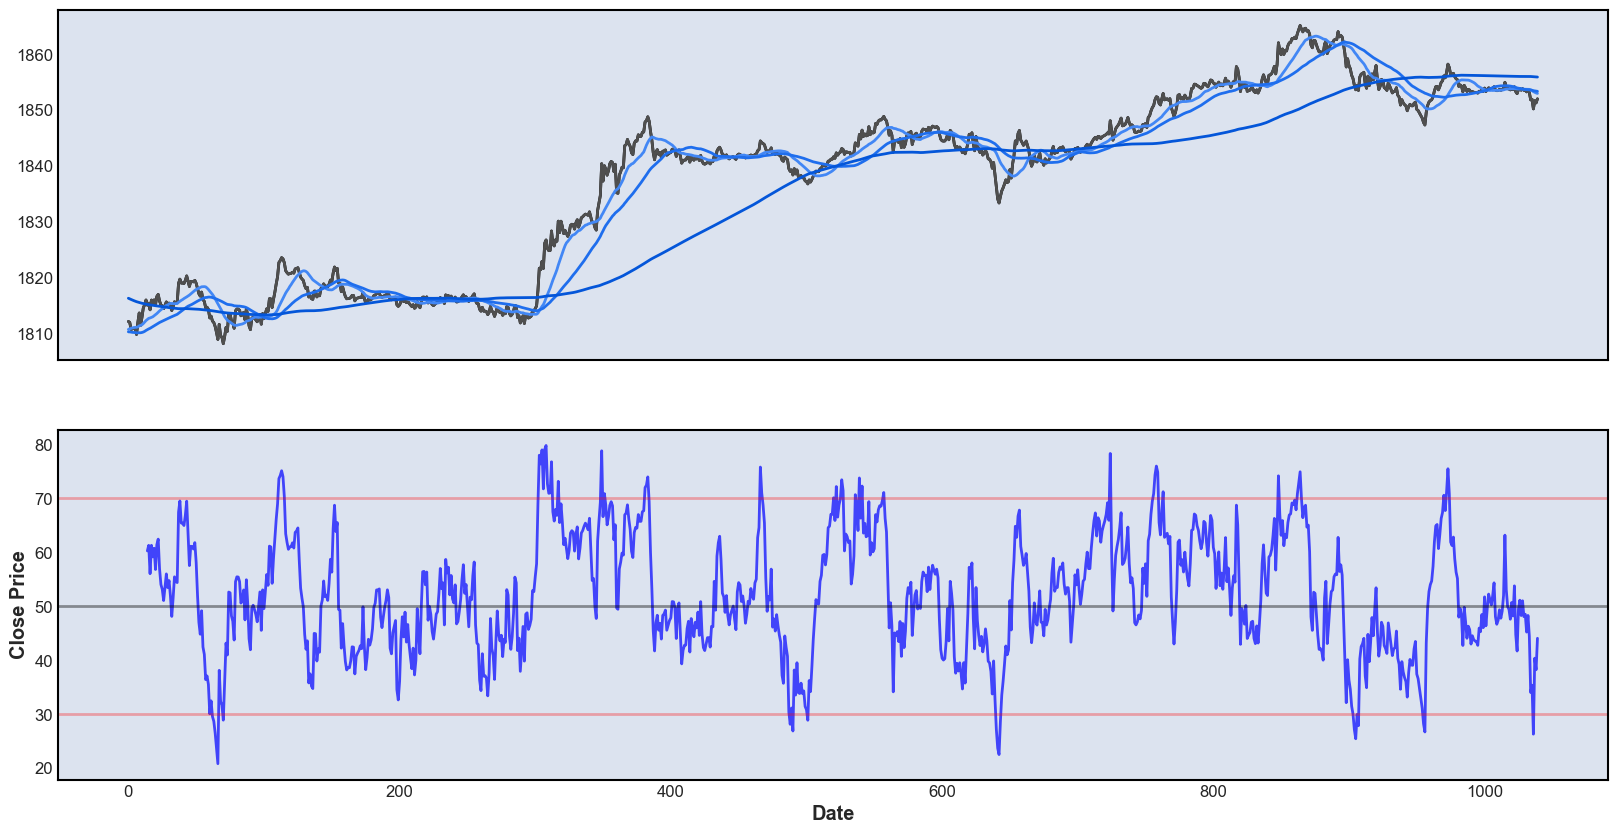

In [18]:
data = calculate_rsi(calculate_sma(data))
plot_chart_with_indicators(data)

## 3. Moving Average Signal
___

In [19]:
def get_sma_direction(open, close, slow, med, fast):
    if slow < med < fast < close:
        return 'bullish'
    elif close < fast < med < slow:
        return 'bearish'
    else:
        return None
    

def sma_signal(df):
    sma_signal = []
    sma_signal_buy = []
    sma_signal_sell = []
    
    for i in range(len(df)):
        close = df.close[i]
        open = df.open[i]
        sma_21 = df.sma_21[i]
        sma_50 = df.sma_50[i]
        sma_200 = df.sma_200[i]
        sma_direction = get_sma_direction(open, close, sma_200, sma_50, sma_21)
        
        if(sma_direction == 'bullish'):
            sma_signal.append('buy')
            sma_signal_buy.append(close)
            sma_signal_sell.append(np.nan)
        elif(sma_direction == 'bearish'):
            sma_signal.append('sell')
            sma_signal_sell.append(close)
            sma_signal_buy.append(np.nan)
        else:
            sma_signal.append(None)
            sma_signal_buy.append(np.nan)
            sma_signal_sell.append(np.nan)
    
    df['sma_signal'] = sma_signal
    return (df, sma_signal_buy, sma_signal_sell)

def test_sma_signal(df, sma_signal_buy, sma_signal_sell):
    plt.figure(figsize=(20, 10))
    plt.grid()
    
    # PLot line graph
    plt.plot(df.index, df['close'], color='black')

    # Plot SMA
    plt.plot(df['close'], label='close', color='#4f4f4f')
    plt.plot(df['sma_21'], label='sma_21', color='#4287f5')
    plt.plot(df['sma_50'], label='sma_50', color='#1f6eed')
    plt.plot(df['sma_200'], label='sma_200', color='#0456d9')
    
    # PLot buy/sell SMA signal
    plt.scatter(df.index, sma_signal_buy, color='green', label='Buy', marker='o')
    plt.scatter(df.index, sma_signal_sell, color='red', label='Sell', marker='o')
    
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.show()

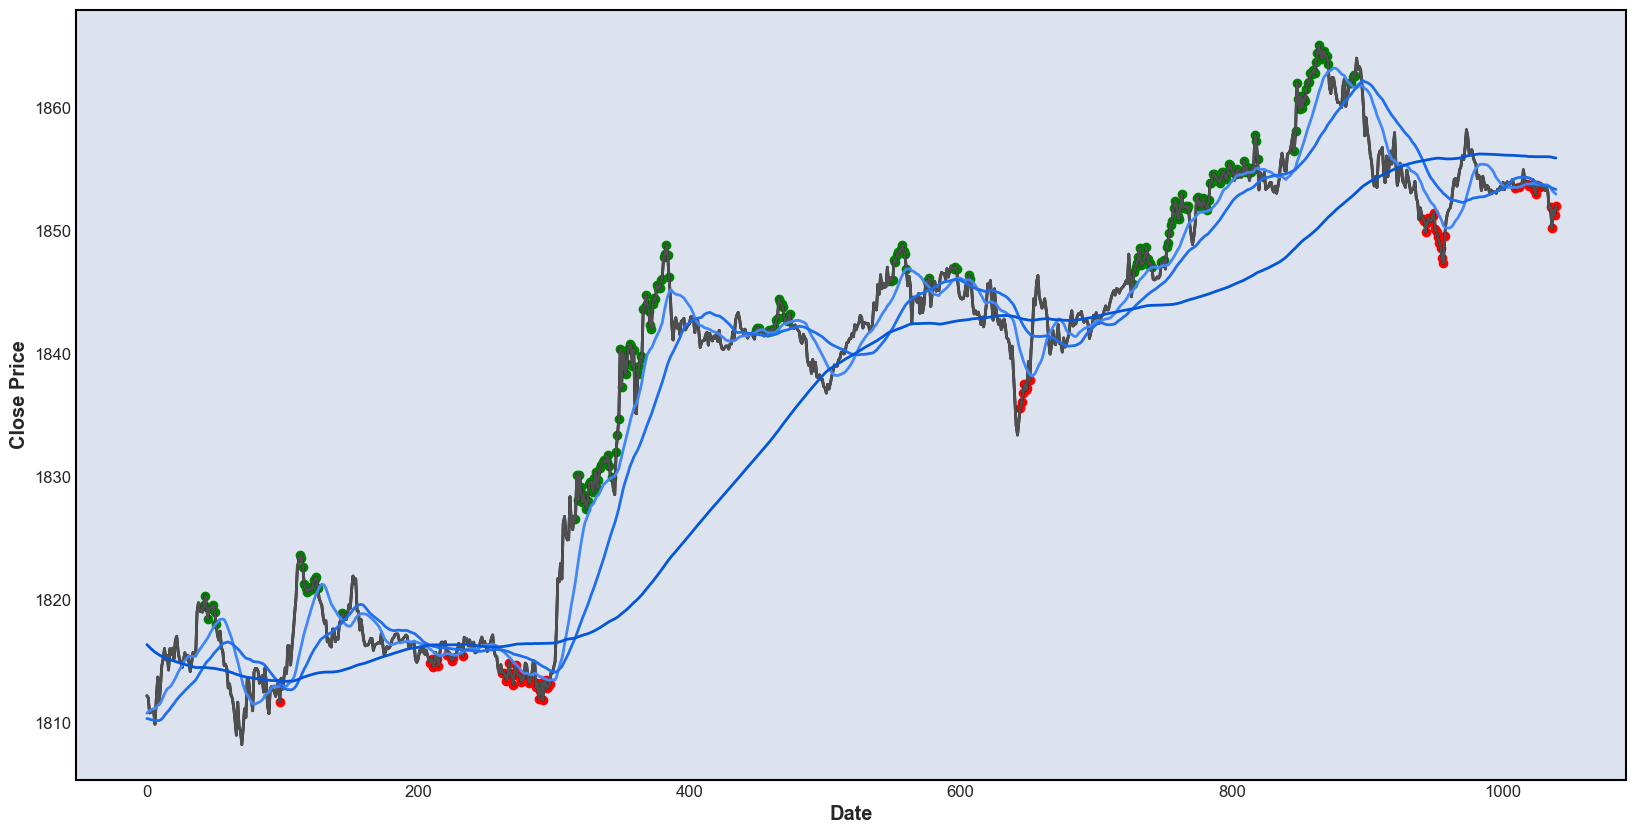

In [20]:
sma = sma_signal(data)
test_sma_signal(sma[0], sma[1], sma[2])

In [21]:
sma[0]

,time,open,high,low,close,sma_21,sma_50,sma_200,rsi,sma_signal
0,2022-05-18 09:25:00,1811.51,1812.47,1811.31,1812.17,1810.751429,1810.3170,1816.32690,NaN,None
1,2022-05-18 09:30:00,1812.17,1812.55,1811.84,1812.01,1810.870476,1810.3058,1816.22530,NaN,None
2,2022-05-18 09:35:00,1812.01,1812.26,1810.40,1810.77,1810.935238,1810.2614,1816.10870,NaN,None
3,2022-05-18 09:40:00,1810.77,1811.08,1810.02,1810.84,1811.023810,1810.2228,1815.99865,NaN,None
4,2022-05-18 09:45:00,1810.87,1811.44,1810.63,1810.96,1811.078095,1810.2104,1815.90085,NaN,None
...,...,...,...,...,...,...,...,...,...,...
1035,2022-05-24 04:00:00,1851.74,1852.26,1851.23,1851.92,1853.511905,1853.5306,1855.98355,35.369225,sell
1036,2022-05-24 04:05:00,1851.91,1851.91,1850.20,1850.20,1853.285714,1853.4562,1855.95695,26.293277,sell
1037,2022-05-24 04:10:00,1850.20,1851.80,1850.06,1851.67,1853.169048,1853.4230,1855.93385,40.375331,sell
1038,2022-05-24 04:15:00,1851.64,1851.76,1850.87,1851.27,1853.047619,1853.3748,1855.91245,38.234690,sell


## 4. RSI signal
___

In [22]:
def get_rsi_direction(open, close, rsi):
    if(open < close):  # bullish
        if(rsi >= 50 and rsi < 70):
            return 'bullish'
        else:
            return None
    else:  # bearish
        if(rsi <= 50 and rsi > 30):
            return 'bearish'
        else:
            return None
        
    
# TODO: once it reaches overbought/sell state, do not produce signal once it reaches 50
def rsi_signal(df):
    rsi_signal = []
    rsi_buy_price = []
    rsi_sell_price = []
    
    for i in range(len(df)):
        open = df.open[i]
        close = df.close[i]
        rsi = df.rsi[i]
        direction = get_rsi_direction(open, close, rsi)
        
        rsi_signal.append(direction)
        
        if(direction == 'bullish'):
            rsi_buy_price.append(close)
            rsi_sell_price.append(np.nan)
        elif(direction == 'bearish'):
            rsi_sell_price.append(close)
            rsi_buy_price.append(np.nan)
        else:
            rsi_buy_price.append(np.nan)
            rsi_sell_price.append(np.nan)
        
    return (rsi_signal, rsi_buy_price, rsi_sell_price)


def test_rsi(df, rsi_buy_price, rsi_sell_price):
    fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
    fig.set_size_inches(20, 10)
    ax1.grid()
    ax2.grid()
    
    # PLot line graph
    ax1.plot(df.index, df['close'], color='black')
    ax1.scatter(df.index, rsi_buy_price, color='green', label='Buy', marker='o')
    ax1.scatter(df.index, rsi_sell_price, color='red', label='Sell', marker='o')
    
    # Plot RSI
    ax2.plot(df.index, df['rsi'], color='blue', alpha=0.7)
    ax2.axhline(y=70, color='red', linestyle='-', alpha=0.3)
    ax2.axhline(y=50, color='black', linestyle='-', alpha=0.4)
    ax2.axhline(y=30, color='red', linestyle='-', alpha=0.3)
    
    
    
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.show()
                   

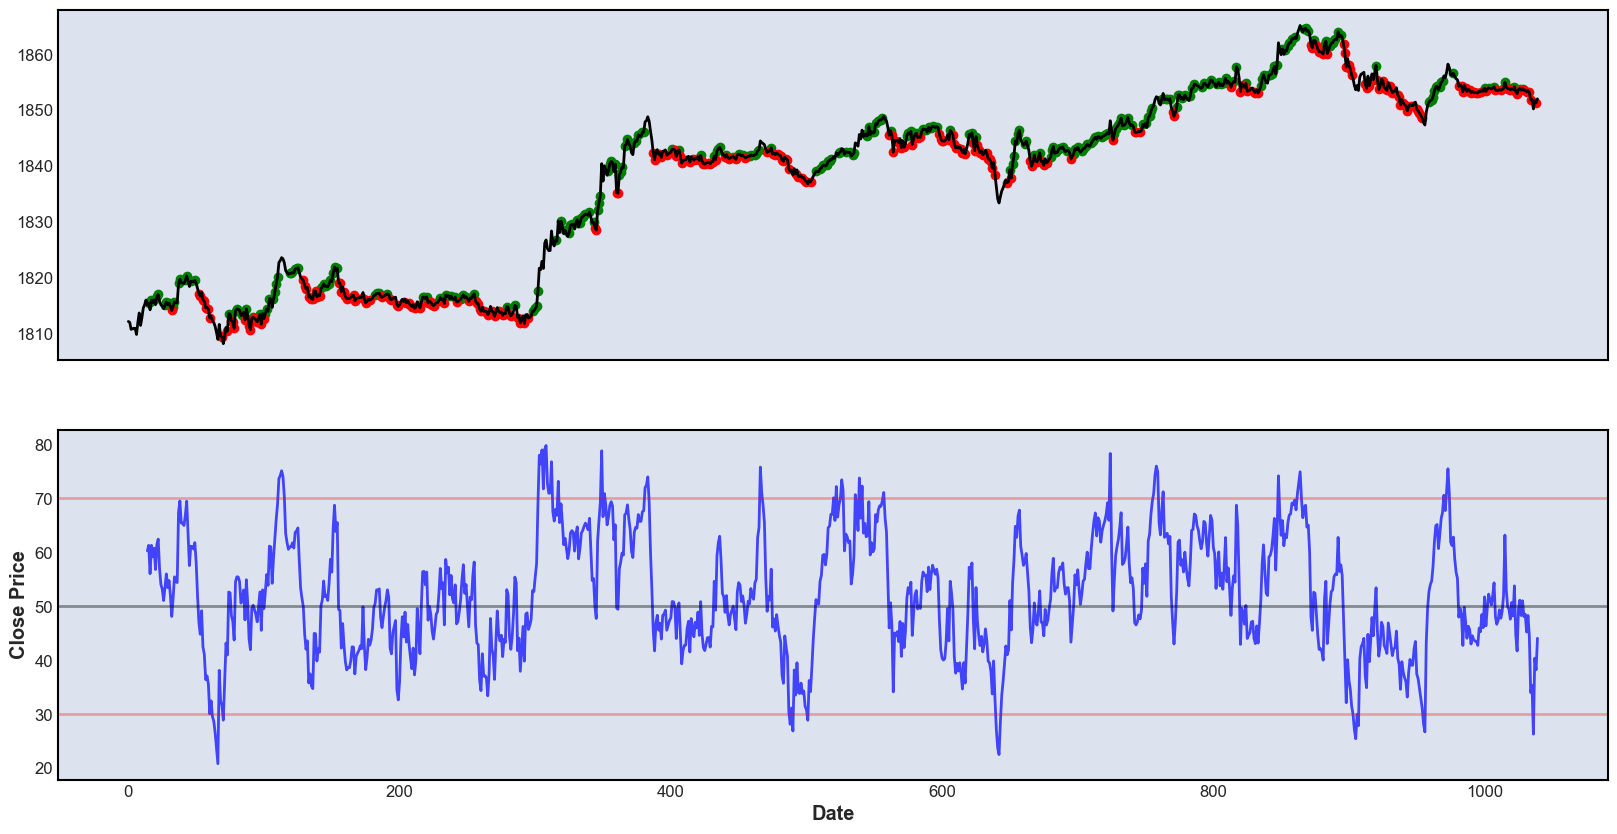

In [23]:
rsi = rsi_signal(data)
test_rsi(data, rsi[1], rsi[2])

## 5. Engulfing Signal
___

In [24]:
import mplfinance as mpf

def get_engulfing_pattern(p_open, p_close, p_high, p_low, c_open, c_close, c_high, c_low):
    prev_range = p_close-p_open
    cur_range = c_close-c_open
    prev_candle = None
    top_wix = 0
    bottom_wix = 0
    
    # bearish --> bullish engulfing
    if(prev_range < 0 and cur_range > 0):
        prev_candle = 'bearish'
        top_wix = c_high - c_close
        bottom_wix = c_open - c_low
        
    # bullish --> bearish engulfing
    elif(prev_range > 0 and cur_range < 0):
        prev_candle = 'bullish'
        top_wix = c_high - c_open
        bottom_wix = c_close - c_low
    
    has_small_wix = ((top_wix + bottom_wix)/(c_high - c_low)) < 0.35    # candle wix must be less than 35% of the range
    is_large_range = abs(cur_range) >= abs(prev_range*1.4)              # current candle must be 1.4 times larger than previous candlee
    
    if(prev_candle == 'bearish' and cur_range > 0 and has_small_wix and is_large_range):
        return 'bullish'
    elif(prev_candle == 'bullish' and cur_range < 0 and has_small_wix and is_large_range):
        return 'bearish'
    else:
        return None

    
def calculate_engulfing(df):
    engulfing_signal = []
    bullish_engulfing_price = []
    bearish_engulfing_price = []
    
    for i in range(len(df)-1):
        s_close = df['close'][i] # slow close
        s_open = df['open'][i]
        s_high = df['high'][i]
        s_low = df['low'][i]
        close = df['close'][i+1] # fast close
        open = df['open'][i+1]
        high = df['high'][i+1]
        low = df['low'][i+1]
        engulfing_pattern = get_engulfing_pattern(s_open, s_close, s_high, s_low, open, close, high, low)
        engulfing_signal.append(engulfing_pattern)
        

        if(engulfing_pattern == 'bullish'):
            bullish_engulfing_price.append(s_close)
            bearish_engulfing_price.append(np.nan)
        elif(engulfing_pattern == 'bearish'):
            bearish_engulfing_price.append(s_close)
            bullish_engulfing_price.append(np.nan)
        else:
            bearish_engulfing_price.append(np.nan)
            bullish_engulfing_price.append(np.nan)
            
        
        
    engulfing_signal.insert(0, None)
    bullish_engulfing_price.insert(0, np.nan)
    bearish_engulfing_price.insert(0, np.nan)
    
#     print(bearish_engulfing_price)
#     print(bullish_engulfing_price)
    return (engulfing_signal, bullish_engulfing_price, bearish_engulfing_price)


In [25]:
# import plotly.graph_objects as go
import mplfinance as mpf

def plot_candlestick(df):
    tmp = df.copy()
    tmp.index = pd.DatetimeIndex(tmp['time'])
    
    # Filter for earliest date 
    #(mpf doesn't recommend too much rendering due to limitation to human eyesights due to squashed candlesticks)
    past = datetime.now()
    week_day = datetime.today().weekday()
    if(week_day == 5): #Saturday
        past=past - timedelta(days=2)
    elif(week_day == 6):
        past=past - timedelta(days=3)
    else:
        past=past - timedelta(days=1)
    
    filtered = tmp.loc[tmp['time'] > past]
    
    ap = [mpf.make_addplot(filtered['engulfing_buy'], type='scatter', marker='^', color='g'),
      mpf.make_addplot(filtered['engulfing_sell'], type='scatter', marker='v', color='r')
     ]

    mpf.plot(filtered, type='candle', mav=(21,50,200), show_nontrading=True, addplot=ap)


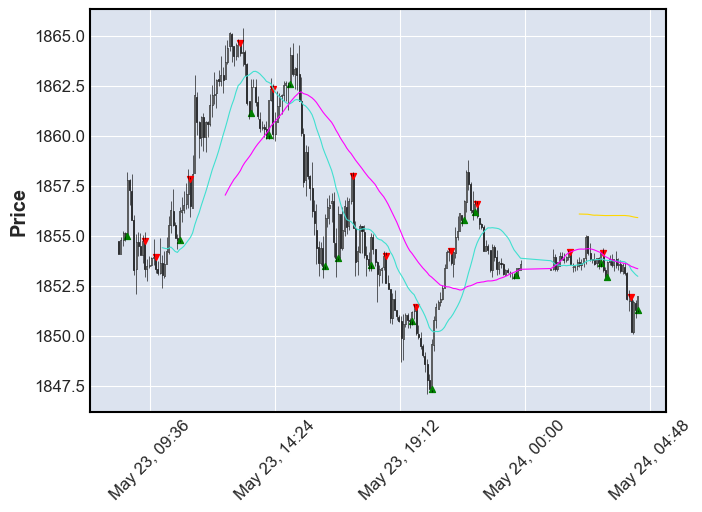

In [26]:
engulfing = calculate_engulfing(data)
engulfing_data = data.copy()
engulfing_data['engulfing_buy'] = engulfing[1]
engulfing_data['engulfing_sell'] = engulfing[2]

plot_candlestick(engulfing_data)

In [63]:
def check_signal(sma, rsi, engulfing):
    return (np.isnan(sma) and np.isnan(rsi) and np.isnan(engulfing)) == False

def strategy(data, sma, rsi, engulfing):
    buy_signal = []
    sell_signal = []
    
    for i in range(len(data)):
        close = data['close'][i]
        sma_buy = sma[1][i]
        sma_sell = sma[2][i]
        rsi_buy = rsi[1][i]
        rsi_sell = rsi[2][i]
        engulfing_buy = engulfing[1][i]
        engulfing_sell = engulfing[2][i]
        
        is_buy_signal_valid = check_signal(sma_buy, rsi_buy, engulfing_buy)
        is_sell_signal_valid = check_signal(sma_sell, rsi_sell, engulfing_sell)
        
        if is_buy_signal_valid == True:
            buy_signal.append(close)
        else:
            buy_signal.append(np.nan)
        
        
        if is_sell_signal_valid == True:
            sell_signal.append(close)
        else:
            sell_signal.append(np.nan)
           
    data['buy_signal'] = buy_signal
    data['sell_signal'] = sell_signal
    
    return data                  

In [64]:
signal = strategy(data, sma, rsi, engulfing)

In [65]:
def plot_signal(df):
    fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
    fig.set_size_inches(20, 10)
    ax1.grid()
    ax2.grid()
    
    # PLot line graph
    ax1.plot(df.index, df['close'], color='black')
    ax1.scatter(df.index, df['buy_signal'], color='green', label='Buy', marker='o')
    ax1.scatter(df.index, df['sell_signal'], color='red', label='Sell', marker='o')
    
    # Plot SMA
    ax1.plot(df['close'], label='close', color='#4f4f4f')
    ax1.plot(df['sma_21'], label='sma_21', color='#4287f5')
    ax1.plot(df['sma_50'], label='sma_50', color='#1f6eed')
    ax1.plot(df['sma_200'], label='sma_200', color='#0456d9')
    
    # Plot RSI
    ax2.plot(df.index, df['rsi'], color='blue', alpha=0.7)
    ax2.axhline(y=70, color='red', linestyle='-', alpha=0.3)
    ax2.axhline(y=50, color='black', linestyle='-', alpha=0.4)
    ax2.axhline(y=30, color='red', linestyle='-', alpha=0.3)
    
    
    
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.show()

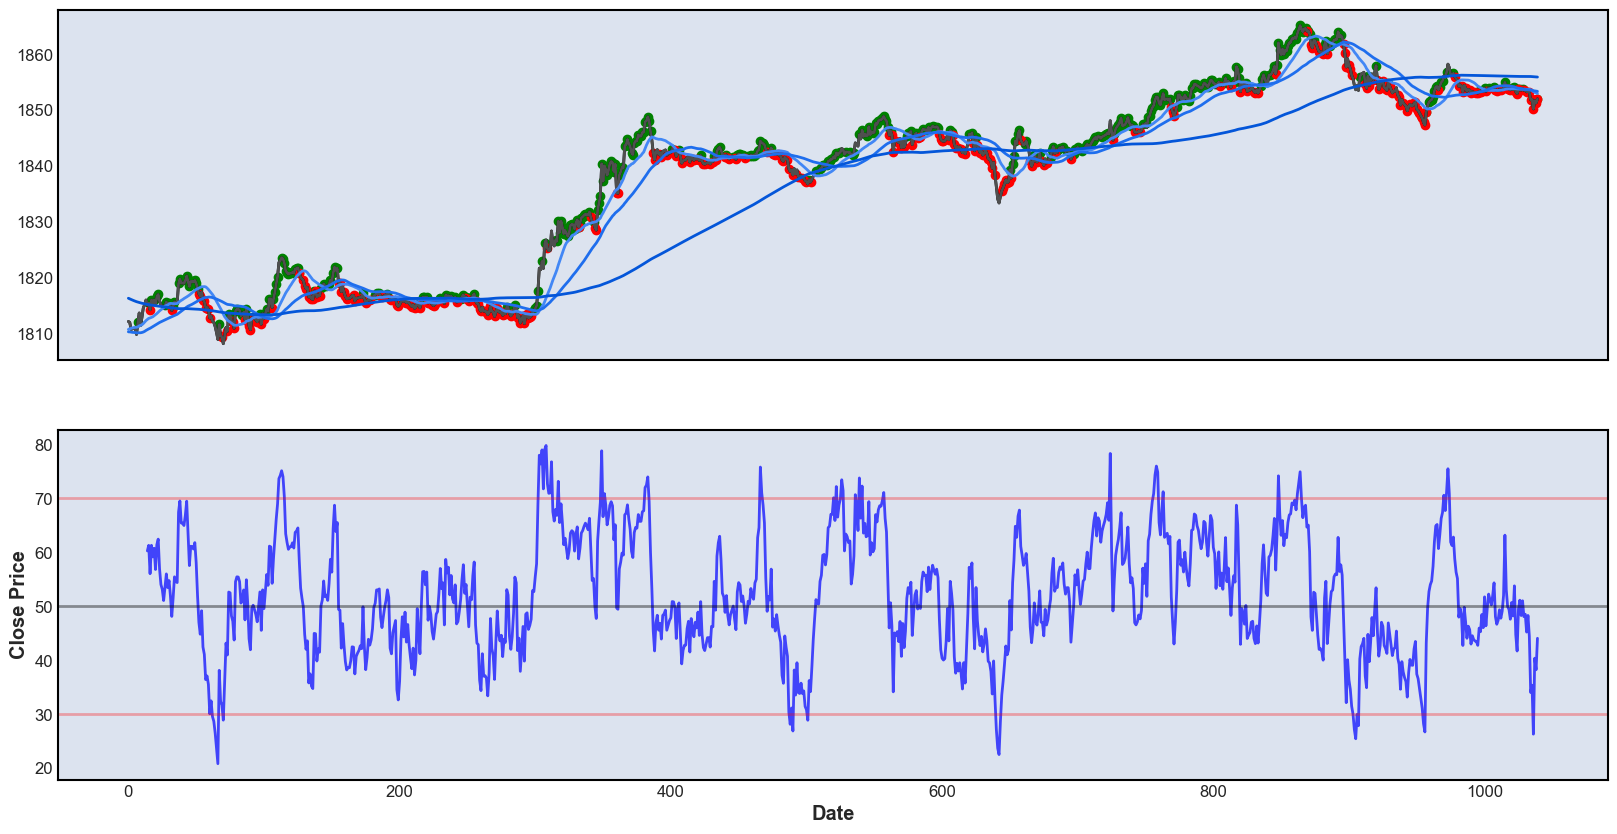

In [66]:
plot_signal(signal)

In [62]:
# print(engulfing[1])
# print(rsi[1])
# print(sma[1])